In [130]:
import numpy as np
from scipy.stats import ttest_ind
from itertools import product
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import matplotlib.pyplot as plt
#non-parameter test
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from random import choices
from __future__ import division
import random

In a nutshell, Mann-Whitney U test still seems to be the best performer, while the bootstrapped t test's performance similar to no adjustment, i,e. treating surrogate metric as the true metric value

## bootstrapped t test algorithm
Reference: https://gist.github.com/johnb30/4166016

In [136]:
def sample(data, size):
    indices = np.random.choice(len(data), size=size, replace=True)
    return data[indices]
def bootstrap_t_test(control, treatment, nboot=1000):
    tstat = np.mean(treatment - control, axis=0)
    tboot = np.zeros((nboot, treatment.shape[1]))

    for j in range(treatment.shape[1]):
        sboot_trt = sample(treatment[:, j], size=(nboot, treatment.shape[0]))
        sboot_null = sample(control[:, j], size=(nboot, control.shape[0]))

        tboot[:, j] = np.mean(sboot_trt - sboot_null, axis=1) - tstat[j]

    pvalue = np.sum(np.abs(tboot) >= np.abs(tstat), axis=0) / nboot
    return pvalue

## Function find_rejection_rate
input: mean, standard deviation, sample size, times of replications, degree of the model(applicable for the polynomial regression only)

In [137]:
def find_rejection_rate(δ, σ, size, n, degree=1):
    # you can define any predictive model
    X, S, Y = model_generator(δ, σ, size, n, degree)
    X_null, X_alt = X
    S_null, S_alt = S
    Y_null, Y_alt = Y
    
    # I simply calculate SSE to be SSTO-SSR in the control group 
    # feel free to replace it by the training/validation error
    sse = np.var(Y[0],0)-np.var(S[0],0)

    p_values_original=ttest_ind(Y_null, Y_alt, axis=0)[1]
    p_values=ttest_ind(S_null, S_alt, axis=0)[1]
    
    diff=np.mean(S_alt-S_null, axis=0)
    pooled_sample_var = (S_alt-S_null).var(ddof=1, axis=0)
    p_values_u = mannwhitneyu(S_null, S_alt,axis=0)[1]
    p_values_bt=bootstrap_t_test(S_null, S_alt)
    #actual metric values
    rej_original = sum(p_values_original<0.05)/n
    # no adjustment
    rej=sum(p_values<0.05)/n
    # non-parametric test - mann whitney
    rej_u=sum(p_values_u<0.05)/n
    # bootstrapped t test
    rej_bt=sum(p_values_bt<0.05)/n
    return [rej_original,rej,rej_u, rej_bt]

Example

In [191]:
find_rejection_rate(5, 1000, 1000, 50)

[0.12, 0.12, 0.12, 0.12]

# Linear model with normal error

In [141]:
def model_generator(δ, σ, size, n, degree=1):
    beta=np.random.uniform(1,10,size=degree+1)
    X = np.random.normal(loc=0, scale=σ, size=(2, size,n))
    X[1, :, :] += δ
    S=0
    for d in range(degree+1):
        S+=(X**d)*beta[d]
    error=np.random.normal(0,σ/5, size=(2,size,n))
    Y=S+error
    return X, S, Y

In [142]:
SIGMA = np.linspace(5, 100, 5)
DELTA = np.linspace(0, 5, 5)
SIZE = range(100, 5000, 500)
REPLICATIONS = 100

results = []
for σ, δ, size in tqdm(product(SIGMA, DELTA, SIZE)):
    rej_rates=find_rejection_rate(δ, σ, size, REPLICATIONS)
    results.extend([{
        'rejection_rate': rej_rate,
        'σ': σ,
        'δ': δ,
        'sample_size': size,
    } for rej_rate in rej_rates])
    

results = pd.DataFrame(results)
results['method']=['original','no_adj','mwu','bt']*int(results.shape[0]/4)

250it [35:41,  8.57s/it]


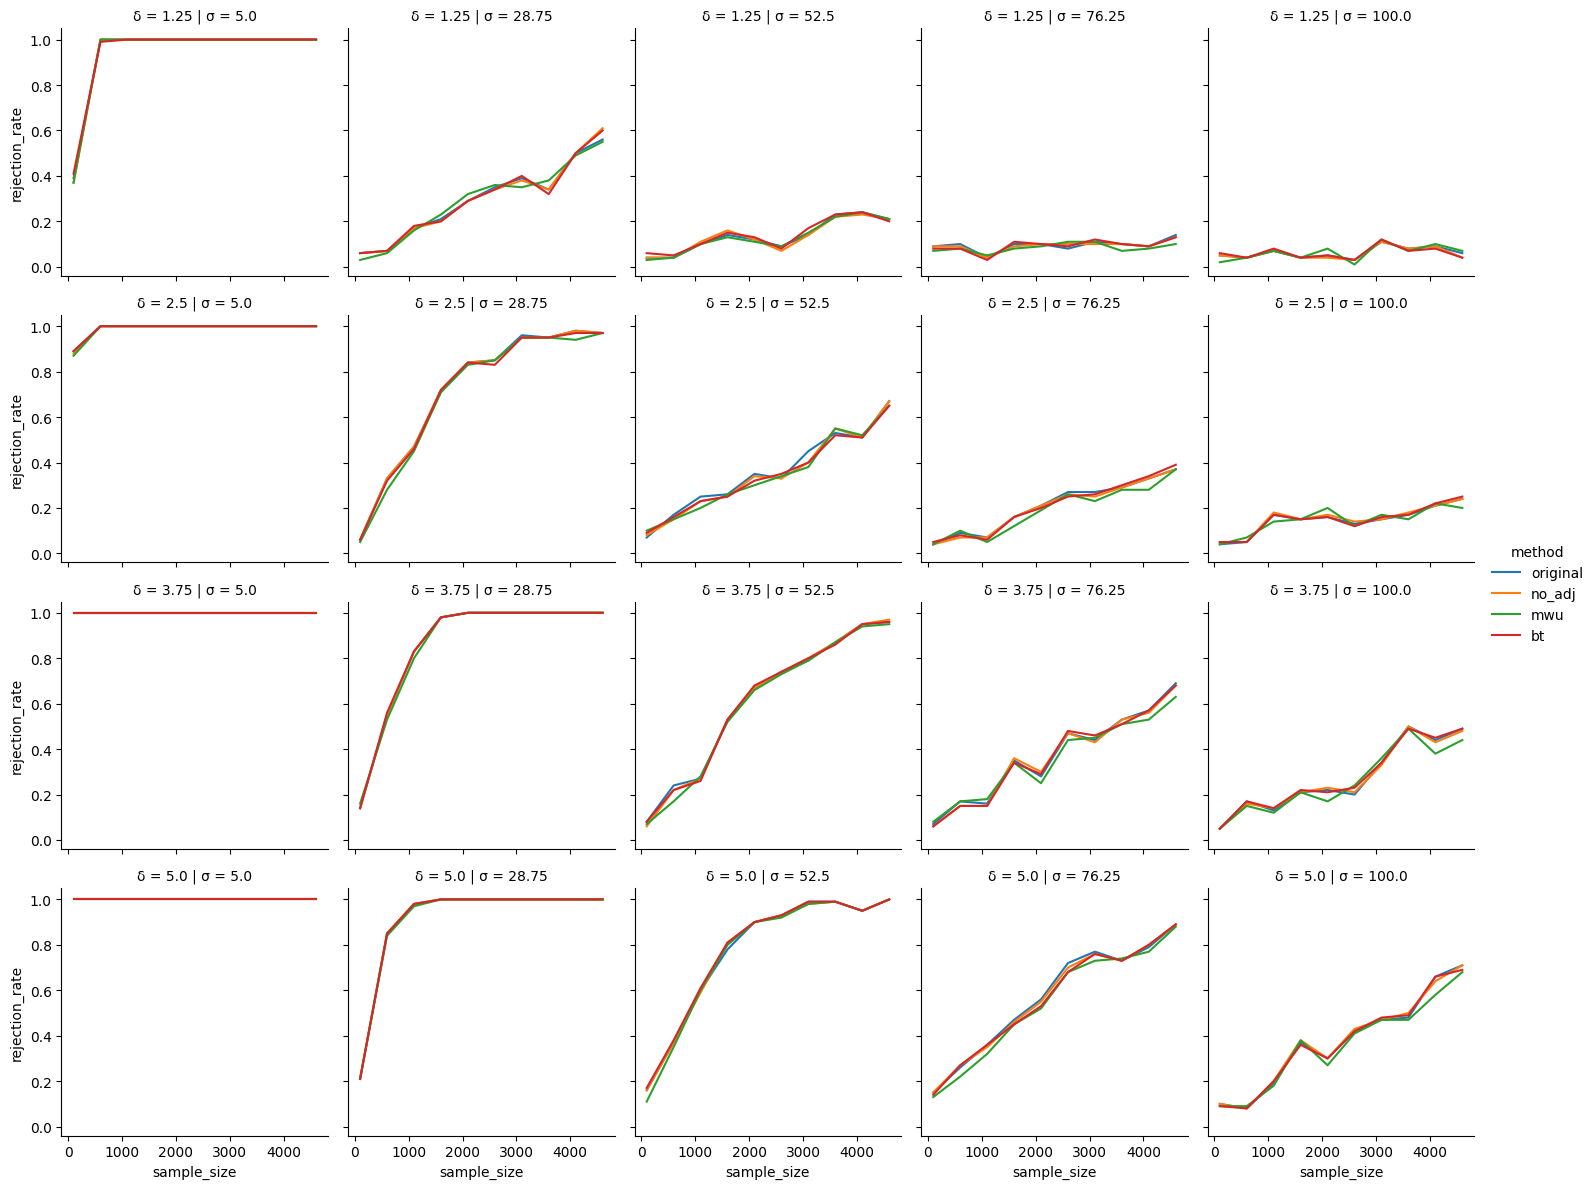

In [143]:
# delta != 0
# rejection_rate is the statistical power
g = sns.FacetGrid(results[results['δ']!=0], col="σ",  row="δ",  hue='method')
g.map(sns.lineplot, "sample_size", "rejection_rate")
g.add_legend()

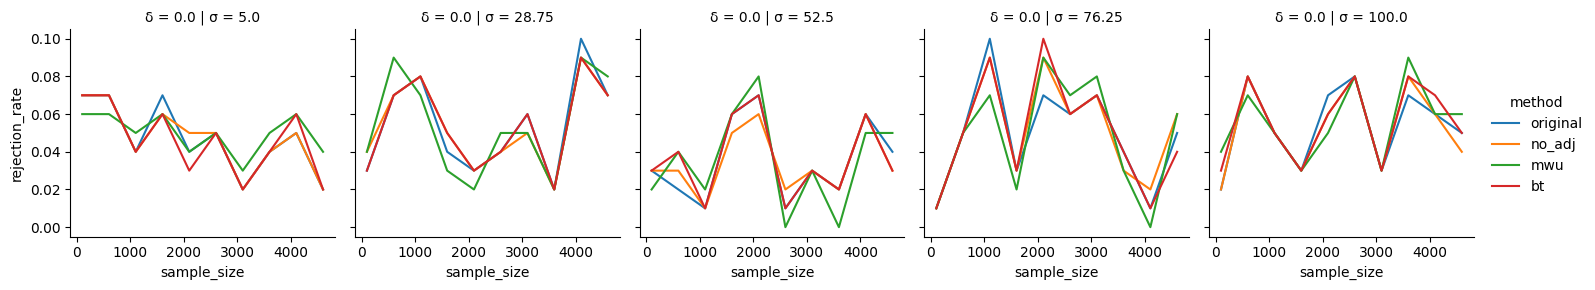

In [144]:
# delta == 0
# rejection_rate is the type I error
g = sns.FacetGrid(results[results['δ']==0], col="σ",  row="δ",  hue='method')
g.map(sns.lineplot, "sample_size", "rejection_rate")
g.add_legend()

# polynomial regression with gamma-distributed error term

In [145]:
def model_generator(δ, σ, size, n, degree=1):
    beta=np.random.uniform(1,10,size=degree+1)
    X = np.random.normal(loc=0, scale=σ, size=(2, size,n))
    X[1, :, :] += δ
    S=0
    for d in range(degree+1):
        S+=(X**d)*beta[d]
    # error's values are proportional to S, otherwise (Y-S)/Y is too close to 0%
    # you can test any prediction error distribution here
    error=np.random.default_rng().gamma(np.abs(np.mean(S))/5,np.abs(np.mean(S))/2, size=(2, size,n))
    Y=S+error
    return X, S, Y

(array([  5.,  47., 157., 264., 251., 167.,  66.,  24.,  13.,   6.]),
 array([ 2308.56867079,  3192.01522604,  4075.4617813 ,  4958.90833656,
         5842.35489181,  6725.80144707,  7609.24800232,  8492.69455758,
         9376.14111283, 10259.58766809, 11143.03422334]),
 <BarContainer object of 10 artists>)

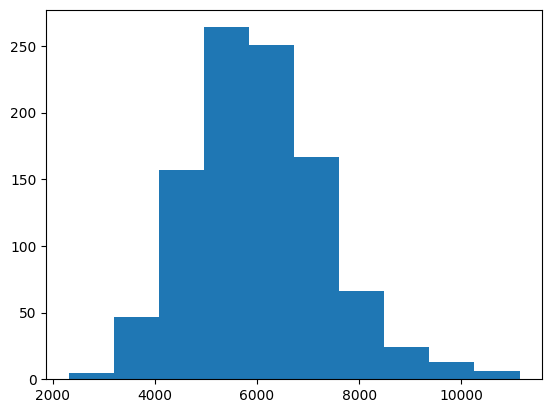

In [146]:
plt.hist(np.random.default_rng().gamma(20, 300, size=1000))

In [147]:
SIGMA = np.linspace(5, 70, 5)
DELTA = np.linspace(0, 5, 5)
SIZE = range(100, 5000, 500)
REPLICATIONS = 100

results_gamma = []
for σ, δ, size in tqdm(product(SIGMA, DELTA, SIZE)):
    rej_rates=find_rejection_rate(δ, σ, size, REPLICATIONS, 3)
    results_gamma.extend([{
        'rejection_rate': rej_rate,
        'σ': σ,
        'δ': δ,
        'sample_size': size,
    } for rej_rate in rej_rates])
    
    
results_gamma = pd.DataFrame(results_gamma)
results_gamma['method']=['original','no_adj','mwu','bt']*int(results_gamma.shape[0]/4)

250it [35:22,  8.49s/it]


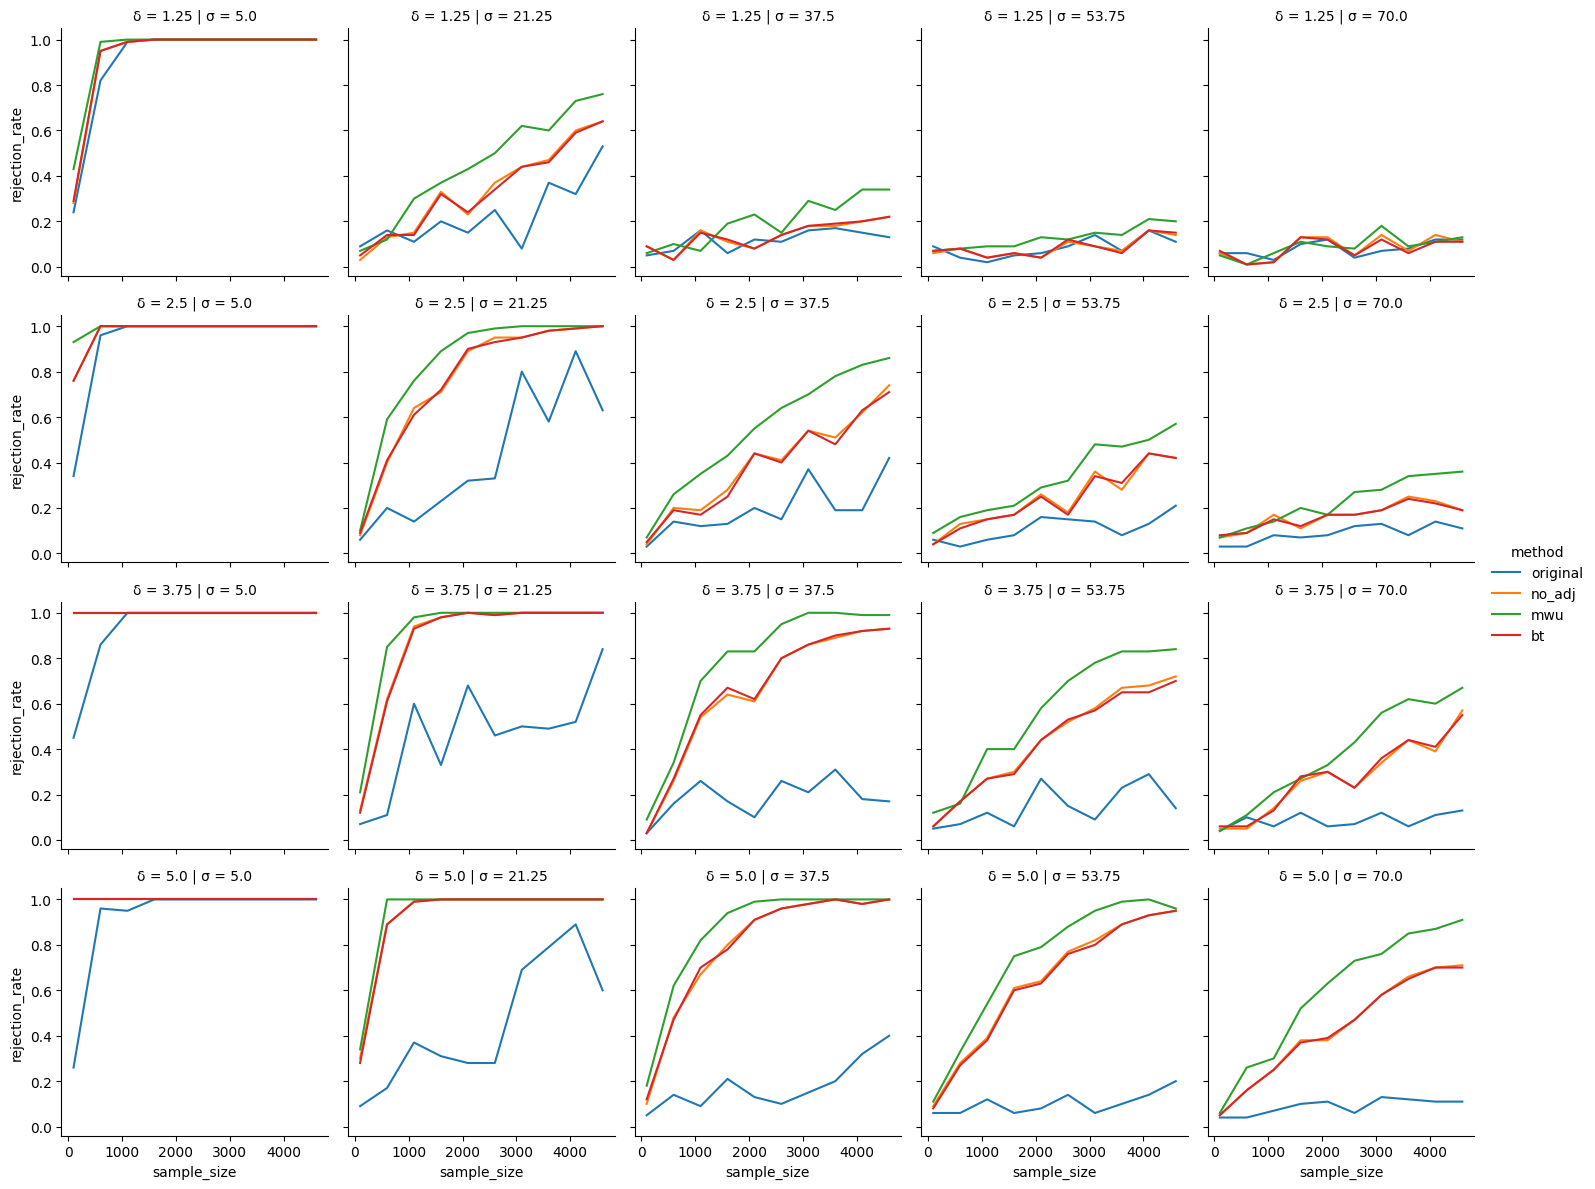

In [148]:
# delta != 0
# rejection_rate is the statistical power
g = sns.FacetGrid(results_gamma[results_gamma['δ']!=0], col="σ",  row="δ",  hue='method')
g.map(sns.lineplot, "sample_size", "rejection_rate")
g.add_legend()

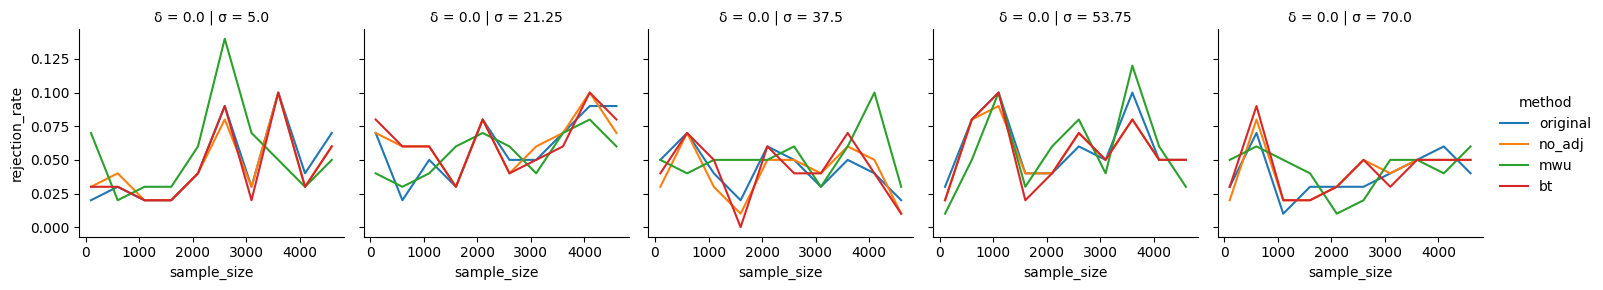

In [149]:
# delta == 0
# rejection_rate is the type I error
g = sns.FacetGrid(results_gamma[results_gamma['δ']==0], col="σ",  row="δ",  hue='method')
g.map(sns.lineplot, "sample_size", "rejection_rate")
g.add_legend()

# Gradient Boosting Regression with Exponential Error Term

In [150]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [171]:
def model_generator(δ, σ, size, n, degree=1):
    # make some random regressor
    x, y = make_regression(n_samples=size, random_state=6, bias=0.5, n_features=1)
    X_train, X_test, y_train, y_test = train_test_split(x,y, random_state=0)
    reg = GradientBoostingRegressor(random_state=0)
    reg.fit(X_train, y_train)
    # apply the regressor to the dataset
    X=np.random.normal(loc=0, scale=σ, size=(2, size,n))
    X[1, :, :] += δ
    S=np.empty(shape=(2, size,n))
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            S[i,:,j]=reg.predict(np.reshape(X[i,:,j], (size, -1)))
    error=np.random.exponential(abs(np.mean(S))/5, size=(2,size,n))
    Y=S+error
    return X, S, Y

(array([568., 229., 113.,  55.,  22.,   8.,   2.,   2.,   0.,   1.]),
 array([2.32990296e-01, 3.20110001e+02, 6.39987011e+02, 9.59864022e+02,
        1.27974103e+03, 1.59961804e+03, 1.91949505e+03, 2.23937206e+03,
        2.55924907e+03, 2.87912608e+03, 3.19900310e+03]),
 <BarContainer object of 10 artists>)

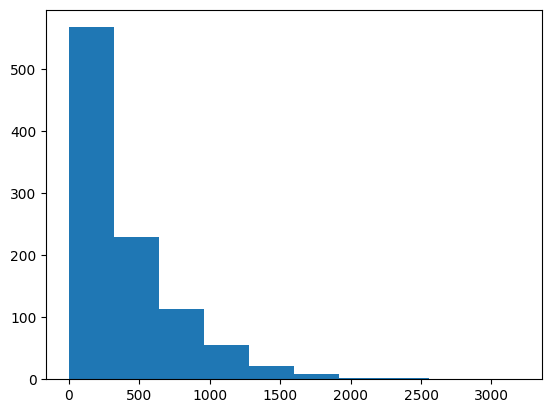

In [172]:
plt.hist(np.random.exponential(400, size=1000))

In [173]:
SIGMA = np.linspace(5, 70, 5)
DELTA = np.linspace(0, 5, 5)
SIZE = range(100, 5000, 500)
REPLICATIONS = 100

results_exp = []
for σ, δ, size in tqdm(product(SIGMA, DELTA, SIZE)):
    rej_rates=find_rejection_rate(δ, σ, size, REPLICATIONS)
    results_exp.extend([{
        'rejection_rate': rej_rate,
        'σ': σ,
        'δ': δ,
        'sample_size': size,
    } for rej_rate in rej_rates])
    
    
results_exp = pd.DataFrame(results_exp)
results_exp['method']=['original','no_adj','mwu','bt']*int(results_exp.shape[0]/4)

250it [1:37:01, 23.29s/it]  


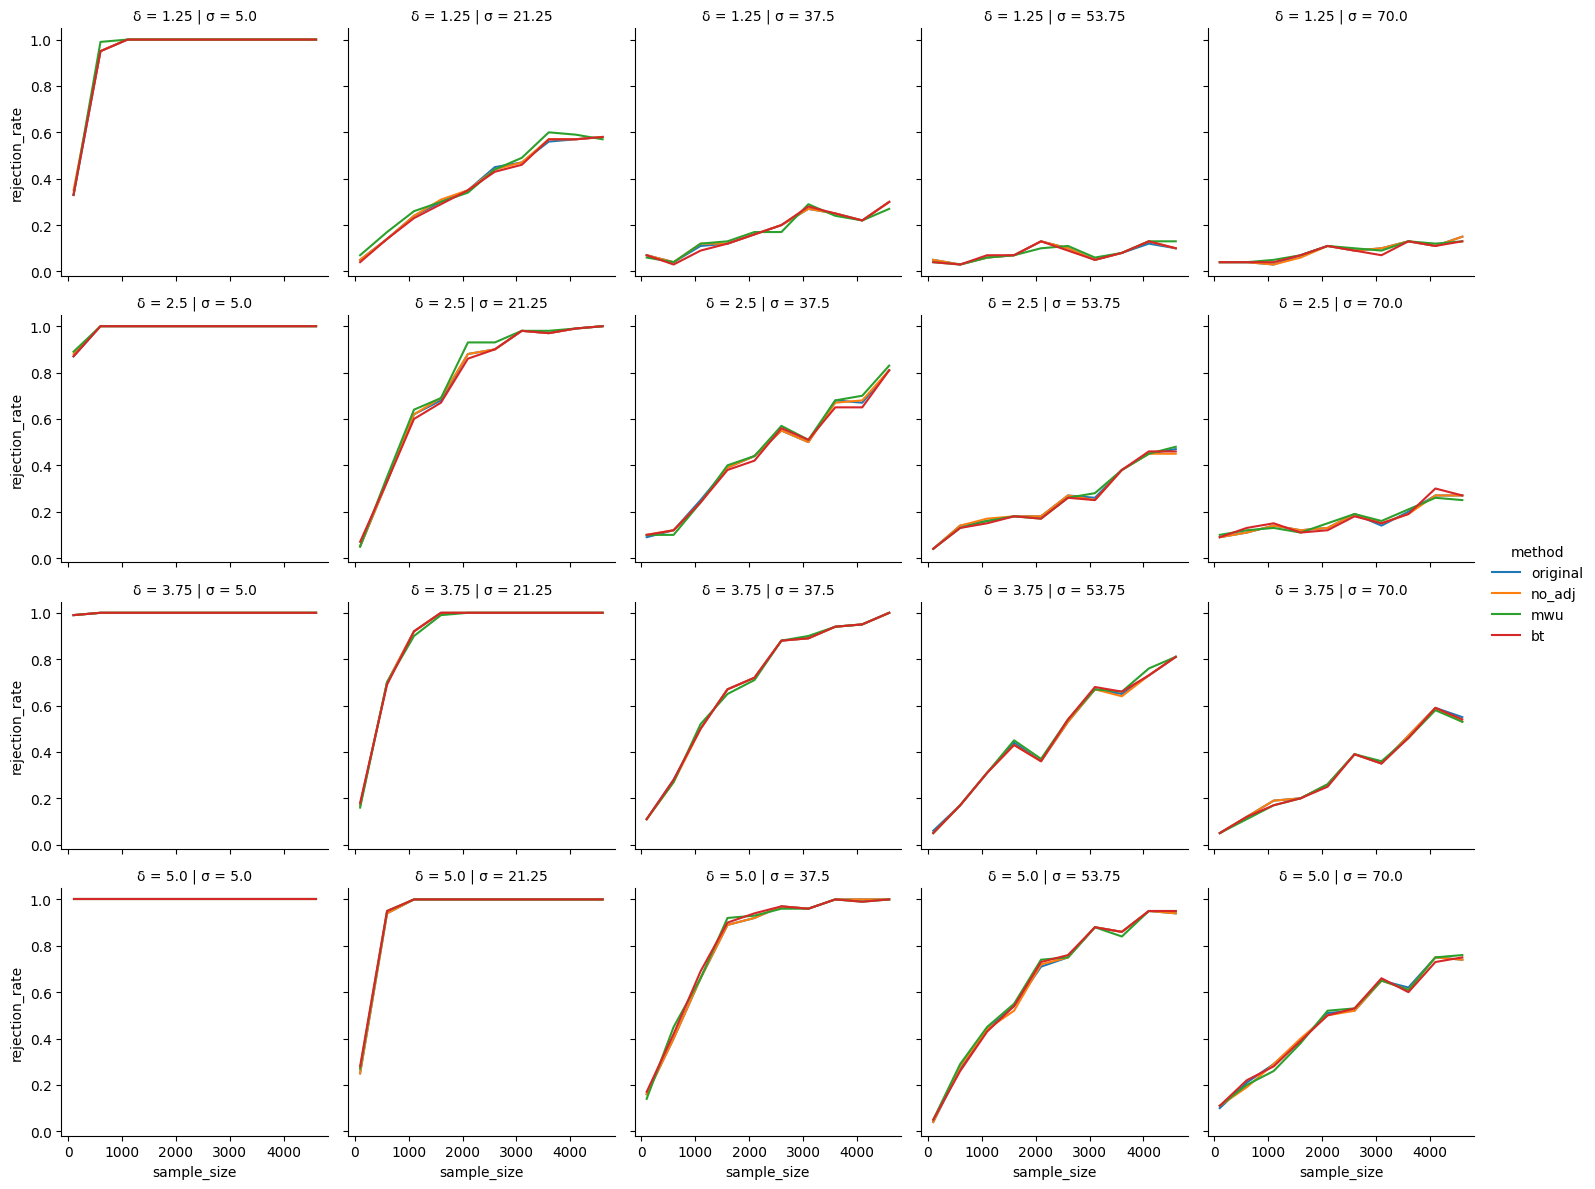

In [174]:
# delta != 0
# rejection_rate is the statistical power
g = sns.FacetGrid(results_exp[results_exp['δ']!=0], col="σ",  row="δ",  hue='method')
g.map(sns.lineplot, "sample_size", "rejection_rate")
g.add_legend()

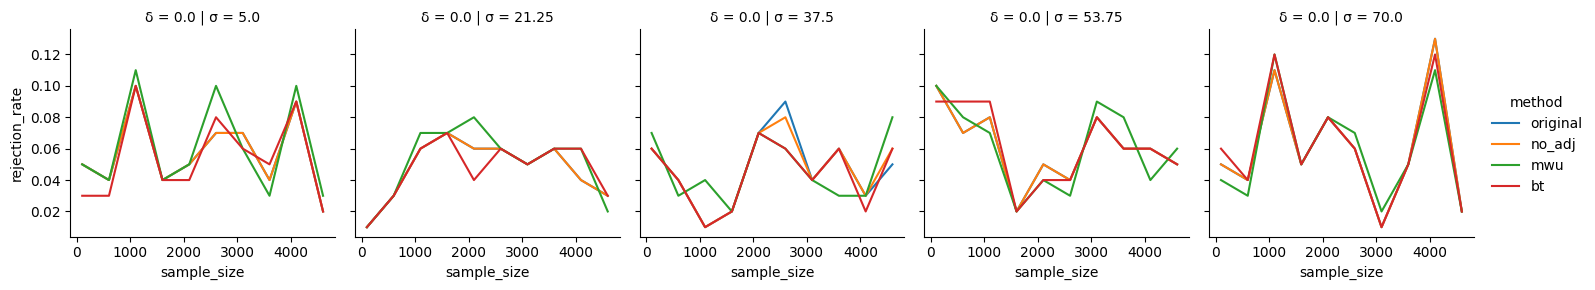

In [175]:
# delta == 0
# rejection_rate is the type I error
g = sns.FacetGrid(results_exp[results_exp['δ']==0], col="σ",  row="δ",  hue='method')
g.map(sns.lineplot, "sample_size", "rejection_rate")
g.add_legend()